In [1]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T

from pyro.distributions.transforms import Transform
from pyro.distributions import TransformModule

from torch.distributions import constraints

(-10.0, 10.0)

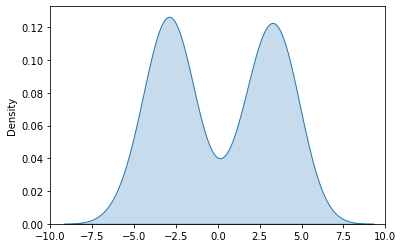

In [2]:
d = 1

dataset = torch.cat([torch.randn(64, d) -3, torch.randn(64, d) + 3])

rng = [-10, 10]

sns.kdeplot(dataset.squeeze(), fill=True, thresh=0, cmap="copper", levels=32)
plt.xlim(*rng)




In [3]:
class LowerCholeskyAffine(Transform):
    """
    A bijection of the form,

        :math:`\\mathbf{y} = \\mathbf{L} \\mathbf{x} + \\mathbf{r}`

    where `\\mathbf{L}` is a lower triangular matrix and `\\mathbf{r}` is a vector.

    :param loc: the fixed D-dimensional vector to shift the input by.
    :type loc: torch.tensor
    :param scale_tril: the D x D lower triangular matrix used in the transformation.
    :type scale_tril: torch.tensor

    """
    codomain = constraints.real_vector
    bijective = True
    event_dim = 1
    volume_preserving = False

    def __init__(self):
        super().__init__(cache_size=1)        
        
    def _get_scale_tril(self, input):
        d = self.input_dim
        scale_tril = torch.zeros(d, d, device=input.device)
        scale_tril[self.ix[0], self.ix[1]] = input
        scale_tril[range(d), range(d)] = torch.exp(scale_tril[range(d), range(d)])
        return scale_tril

    
    def _call(self, x):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        return torch.matmul(scale_tril, x.unsqueeze(-1)).squeeze(-1) + loc

    def _inverse(self, y):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        
        
#         x_ = torch.triangular_solve((y - loc).unsqueeze(-1), scale_tril,
#                                       upper=False, transpose=False)[0].squeeze(-1)
        x = torch.linalg.solve_triangular(scale_tril, (y - loc).unsqueeze(-1),
                              upper=False).squeeze(-1)
        

        return x

    def log_abs_det_jacobian(self, x, y):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        J = torch.ones(x.size(), dtype=x.dtype, layout=x.layout, device=x.device) * \
            scale_tril.diag().log()
        J = J.sum(-1)
        return J
        
class LowerCholeskyAffineModule(LowerCholeskyAffine, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim * (input_dim + 1) // 2))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.ix = torch.tril_indices(input_dim, input_dim)
        self.reset_parameters()

    
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()


    




In [4]:
import math

class ConditionedAffineMatrixExponential(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, iterations=8, normalization="none", bound=None):
        super().__init__(cache_size=1)
        assert iterations > 0
        self.weights = weights
        self.bias = bias
        self.iterations = iterations
        self.normalization = normalization
        self.bound = bound

        # Currently, weight and spectral normalization are unimplemented. This doesn't effect the validity of the
        # bijection, although applying these norms should improve the numerical conditioning of the approximation.
        if normalization == "weight" or normalization == "spectral":
            raise NotImplementedError("Normalization is currently not implemented.")
        elif normalization != "none":
            raise ValueError("Unknown normalization method: {}".format(normalization))

    def _exp(self, x, M):
        
        power_term = x.unsqueeze(-1)
        y = x.unsqueeze(-1)
        for idx in range(self.iterations):
            power_term = torch.matmul(M, power_term) / (idx + 1)
            y = y + power_term

        return y.squeeze(-1)

    def _trace(self, M):
        return M.diagonal(dim1=-2, dim2=-1).sum(-1)

    def _call(self, x):

        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        return self._exp(x, M) + b

    def _inverse(self, y):
        b = self.bias() if callable(self.bias) else self.bias
        M = self.weights() if callable(self.weights) else self.weights
        return self._exp(y - b, -M)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the element-wise determinant of the log Jacobian
        """

        M = self.weights() if callable(self.weights) else self.weights
        return self._trace(M)

class AffineMatrixExponentialModule(ConditionedAffineMatrixExponential, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, iterations=8, normalization="none", bound=None):
        super().__init__(
            iterations=iterations, normalization=normalization, bound=bound
        )

        self.weights = nn.Parameter(torch.Tensor(input_dim, input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()



In [5]:
class PositivePowerTransform(Transform):
    r"""
    Transform via the mapping
    :math:`y=\operatorname{sign}(x)|x|^{\text{exponent}}`.

    Whereas :class:`~torch.distributions.transforms.PowerTransform` allows
    arbitrary ``exponent`` and restricts domain and codomain to postive values,
    this class restricts ``exponent > 0`` and allows real domain and codomain.

    .. warning:: The Jacobian is typically zero or infinite at the origin.
    """
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, exponent, *, cache_size=0, validate_args=None):
        super().__init__(cache_size=cache_size)
#         if isinstance(exponent, int):
#             exponent = float(exponent)
#         exponent = torch.as_tensor(exponent)
#         self.exponent = exponent
    def with_cache(self, cache_size=1):
        if self._cache_size == cache_size:
            return self
        return PositivePowerTransform(self.exponent, cache_size=cache_size)


#     def __eq__(self, other):
#         if not isinstance(other, PositivePowerTransform):
#             return False
#         return self.exponent.eq(other.exponent).all().item()

    def _call(self, x):
#         exponent = F.softplus(self.exponent)
        e = self.exponent.exp()
#         exponent = self.exponent.exp()
        return x.abs().pow(e) * x.sign()

    def _inverse(self, y):
#         exponent = self.exponent.exp()
#         exponent = F.softplus(self.exponent)
        e = self.exponent.exp()

        return y.abs().pow(e.reciprocal()) * y.sign()

    def log_abs_det_jacobian(self, x, y):
#         e = F.softplus(self.exponent)
        e = self.exponent.exp()
        J = e.log() + (y / x).log()
        return J.sum(-1)


#     def forward_shape(self, shape):
# #         e = F.softplus(self.exponent)
#         e = self.exponent.exp()
#         return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


#     def inverse_shape(self, shape):
# #         e = F.softplus(self.exponent)
#         e = self.exponent.exp()
#         return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    
class PositivePowerTransformModule(PositivePowerTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__(None)
        self.exponent = nn.Parameter(torch.zeros(input_dim))




In [6]:
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 2
transform = []
for l in range(num_layers - 1):
#     transform.append(T.affine_coupling(1))
    transform.append(LowerCholeskyAffineModule(d))
#     transform.append(AffineMatrixExponentialModule(d))


#     transform.append(T.MatrixExponential(d))
#     transform.append(MatrixExponential(d))
#     transform.append(T.SoftplusTransform())
#     transform.append(LeakyReLUTransform(d))
#     transform.append(LeakyReLUTransformModule())
    transform.append(PositivePowerTransformModule(d))
#     transform.append(T.ELUTransform())
transform.append(LowerCholeskyAffineModule(d))
# transform.append(MatrixExponential(d))
# transform.append(AffineMatrixExponentialModule(d))




transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)



In [7]:
x = torch.randn(3, 3)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(transform_modules)

5

In [9]:
x = torch.linspace(-5, 5, 32)

In [10]:
y = flow_dist.sample((1024,))

<AxesSubplot:ylabel='Density'>

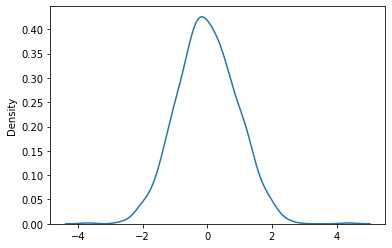

In [11]:
sns.kdeplot(y.detach().squeeze())

In [12]:
flow_dist.log_prob(x[:, None]).shape

torch.Size([32])

In [13]:
x = torch.linspace(-5, 5, 32768)

In [14]:
flow_dist.log_prob(x[:, None])

tensor([-16.4825, -16.4806, -16.4787,  ..., -16.4787, -16.4806, -16.4825],
       grad_fn=<AddBackward0>)

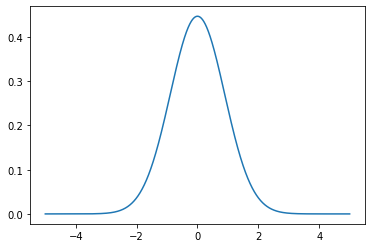

In [15]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [16]:
# matexp = MatrixExponential(d)

In [17]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_probs = log_prob(flow_dist, dataset)

LowerCholeskyAffineModule() tensor(0.0765, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.0765, grad_fn=<MeanBackward0>)
LowerCholeskyAffineModule() tensor(0.1112, grad_fn=<MeanBackward0>)


In [18]:
# print(count_parameters(transform_modules))

In [19]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y)
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


In [20]:
log_prob(flow_dist, x[:, None])

tensor([-16.4825, -16.4806, -16.4787,  ..., -16.4787, -16.4806, -16.4825],
       grad_fn=<AddBackward0>)

step: 0, loss: 7.382852077484131


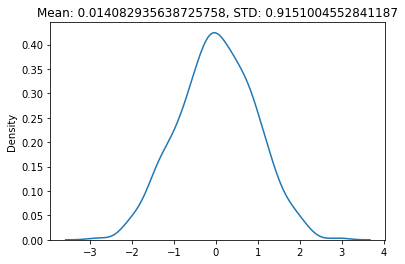

step: 500, loss: 3.224891185760498


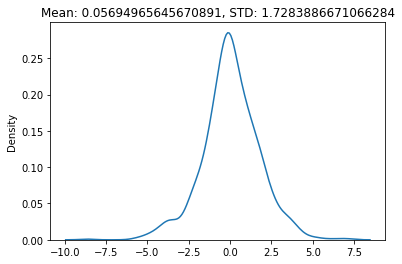

step: 1000, loss: 2.833364963531494


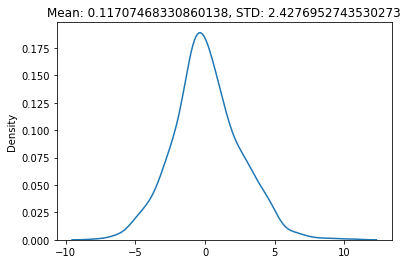

step: 1500, loss: 2.657731056213379


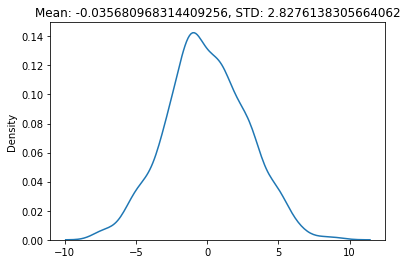

step: 2000, loss: 2.581632375717163


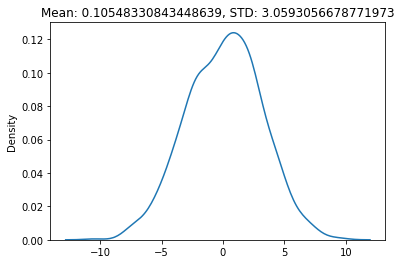

step: 2500, loss: 2.5280117988586426


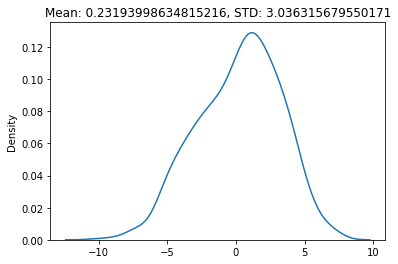

step: 3000, loss: 2.49965763092041


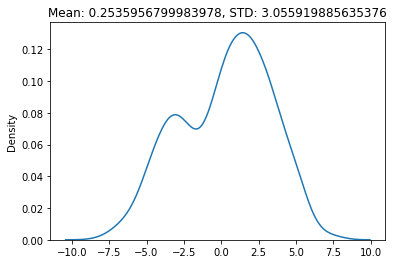

step: 3500, loss: 2.489943504333496


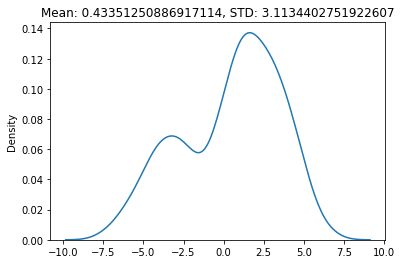

step: 4000, loss: 2.488032817840576


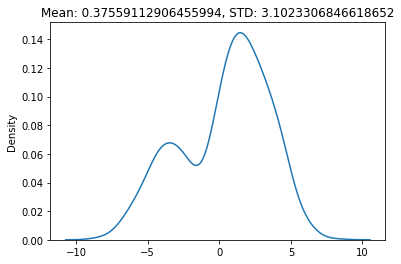

step: 4500, loss: 2.487839937210083


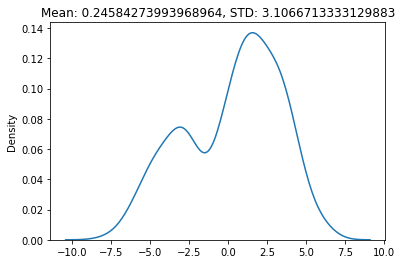

step: 5000, loss: 2.4878311157226562


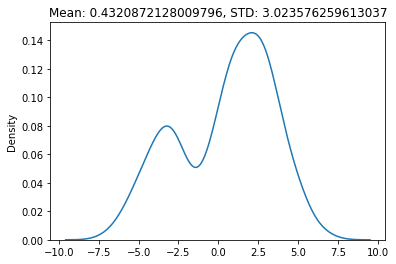

step: 5500, loss: 2.4878313541412354


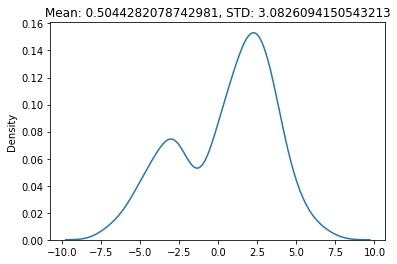

step: 6000, loss: 2.4878311157226562


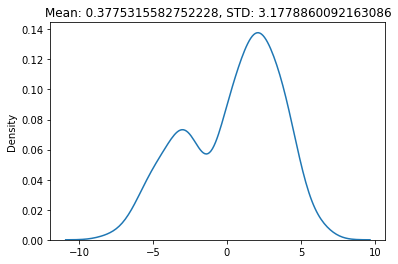

step: 6500, loss: 2.4878311157226562


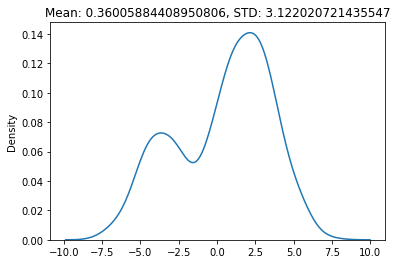

step: 7000, loss: 2.4878311157226562


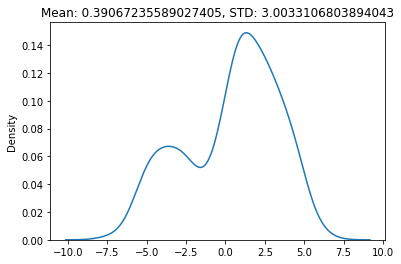

step: 7500, loss: 2.4878311157226562


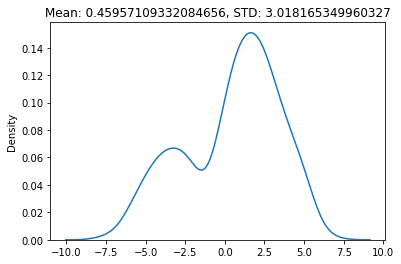

step: 8000, loss: 2.4878311157226562


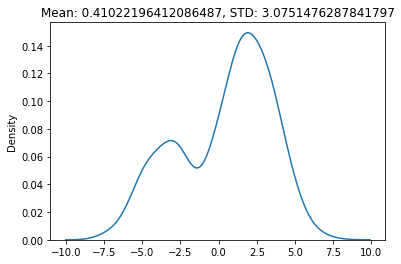

step: 8500, loss: 2.4878311157226562


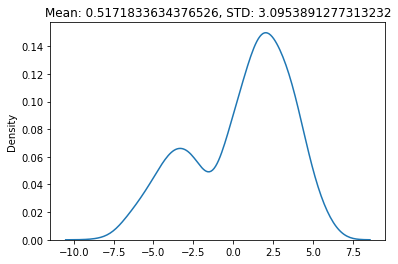

step: 9000, loss: 2.4878311157226562


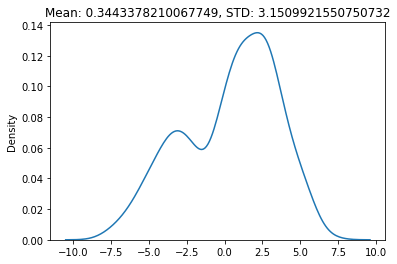

step: 9500, loss: 2.4878311157226562


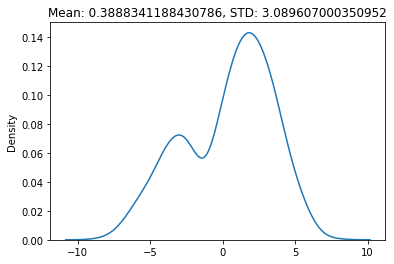

KeyboardInterrupt: 

In [21]:
steps = 32768
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

        sample = flow_dist.sample((1000,)).squeeze().numpy()
        sns.kdeplot(sample)
        plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")
        plt.show()

In [ ]:
with torch.no_grad():
    sample = flow_dist.sample((1000,)).squeeze().numpy()
    sns.kdeplot(sample)
    plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")

In [ ]:
x = torch.linspace(-8, 8, 128)

In [ ]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [ ]:
sns.kdeplot(dataset.squeeze())

In [ ]:
# 